In [19]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 10]

import os
import sys
import inspect
module_path = os.path.abspath(os.path.join('..'))
print(module_path)
if module_path not in sys.path:
    sys.path.append(module_path)

import importlib
import dataset.dataset
import dataset.loader
importlib.reload(dataset.dataset)
importlib.reload(dataset.loader)

from dataset.dataset import get_test_datasets, get_validation_datasets, get_dataset_shapes
from network import vlayers
importlib.reload(vlayers)

D:\RTU\MagD\code\VNN


<module 'network.vlayers' from 'D:\\RTU\\MagD\\code\\VNN\\network\\vlayers.py'>

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
# Create models

def get_keras_model(dataset_shapes):
    input_dims = dataset_shapes[0]
    output_dims = dataset_shapes[1]
    # Create model
    inputs = keras.Input(shape=input_dims)
    x = layers.Dense(9, activation='relu', kernel_initializer='random_normal', bias_initializer='random_normal')(inputs)
    x = layers.Dense(6, activation='relu', kernel_initializer='random_normal', bias_initializer='random_normal')(x)
    x = layers.Dense(4, activation='relu', kernel_initializer='random_normal', bias_initializer='random_normal')(x)
    outputs = layers.Dense(output_dims[-1], activation='relu', kernel_initializer='random_normal', bias_initializer='random_normal')(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(
        #optimizer=keras.optimizers.Adam(),
        optimizer=keras.optimizers.RMSprop(),
        loss=keras.losses.MeanSquaredError(),
        metrics=[keras.metrics.MeanSquaredError()]
    )
    
    return model
                    
def get_simple_vector_model(dataset_shapes):
    input_dims = dataset_shapes[0]
    output_dims = dataset_shapes[1]
    # Create model
    inputs = keras.Input(shape=input_dims)
    x = vlayers.VInput(9, weight_initializer='random_normal')(inputs)
#     x = vlayers.VInput(2, weight_initializer='random_normal')(inputs)
    x = vlayers.VDense(6, activation='relu', weight_initializer='random_normal')(x)
    x = vlayers.VDense(4, activation='relu', weight_initializer='random_normal')(x)
    x = vlayers.VDense(output_dims[-1], activation='relu', weight_initializer='random_normal')(x)
    outputs = vlayers.VOutput(activation='relu')(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=keras.optimizers.RMSprop(),
        loss=keras.losses.MeanSquaredError(),
        metrics=[keras.metrics.MeanSquaredError()]
    )
    
    return model

def get_fractal_vector_model(dataset_shapes, is_shared=False):
    input_dims = dataset_shapes[0]
    output_dims = dataset_shapes[1]
    # Create model
    inputs = keras.Input(shape=input_dims)
    x = vlayers.VInput(4, weight_initializer='random_normal')(inputs)
#     x = vlayers.VInput(2, weight_initializer='random_normal')(inputs)
    x = vlayers.VFractal(output_dims[-1], depth=1, weight_type="shared" if is_shared else "unique", activation='relu', weight_initializer='random_normal')(x)
    outputs = vlayers.VOutput(activation='relu')(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=keras.optimizers.RMSprop(),
        loss=keras.losses.MeanSquaredError(),
        metrics=[keras.metrics.MeanSquaredError()]
    )
    
    return model

In [10]:
# K-fold validation of model
def validate_model(model, datasets_generator):
    history1_sum = np.single(0)
    history2_sum = np.single(0)
    k = 0
    for train_dataset, validation_dataset in datasets_generator:
        history = model.fit(
            train_dataset,
            epochs=50,
            validation_data=validation_dataset,
            verbose=0,
            use_multiprocessing = True
        )
        history1_sum += np.array(history.history['mean_squared_error'], dtype=np.float64)
        history2_sum += np.array(history.history['val_mean_squared_error'], dtype=np.float64)
        k += 1
    
    history1_avr = history1_sum / k
    history2_avr = history2_sum / k
    
    x = range(1, len(history1_avr)+1)
    plt.plot(x, history1_avr, 'b')
    plt.plot(x, history2_avr, 'r--')
    plt.legend(['loss', 'validation'])
    plt.show() 

# Testing of model
def test_model(model, train_dataset, test_dataset):
    history = model.fit(
        train_dataset,
        epochs=50,
        validation_data=test_dataset,
        verbose=0,
        use_multiprocessing = True
    )
    # Visualize validation error
    y1 = history.history['mean_squared_error']
    y2 = history.history['val_mean_squared_error']
    x = range(1, len(y1)+1)
    plt.plot(x, y1, 'b')
    plt.plot(x, y2, 'r--')
    plt.legend(['loss', 'validation'])
    plt.show() 
    
# Testing of model in multiple runs
def test_model_multiple(model_generator, train_dataset, test_dataset, num_tries):
    history1_sum = np.single(0)
    history2_sum = np.single(0)
    validation_worst = None
    validation_best = None
    validation_worst_history = None
    validation_best_history = None
    validations = []
    
    for k in range(num_tries):
        model = model_generator()
        history = model.fit(
            train_dataset,
            epochs=100,
            validation_data=test_dataset,
            verbose=0,
            use_multiprocessing = True
        )
        history1_sum += np.array(history.history['mean_squared_error'], dtype=np.float64)
        
        temp_array = np.array(history.history['val_mean_squared_error'], dtype=np.float64)
        if validation_worst is None or temp_array[-1] > validation_worst:
            validation_worst = temp_array[-1]
            validation_worst_history = temp_array
        if validation_best is None or temp_array[-1] < validation_best:
            validation_best = temp_array[-1]
            validation_best_history = temp_array
        history2_sum += temp_array
        
        validations.append(temp_array[-1])
    
    history1_avr = history1_sum / num_tries
    history2_avr = history2_sum / num_tries
    
    x = range(1, len(history1_avr)+1)
    plt.subplot(2, 1, 1)
    plt.plot(x, history1_avr, 'b')
    plt.plot(x, history2_avr, 'y--')
    plt.plot(x, validation_worst_history, 'r--')
    plt.plot(x, validation_best_history, 'g--')
    plt.legend(['loss avg.', 'validation avg.', 'validation worst', 'validation best'])
    
    plt.subplot(2, 1, 2)
    plt.boxplot(validations)
    
    plt.show(validations) 
    
    print(validations)

### Testing of models in multiple runs

In [12]:
# tr_d, ts_d = get_test_datasets('yacht_hydrodynamics', random_seed=200)
# dataset_shapes = get_dataset_shapes('yacht_hydrodynamics')
tr_d, ts_d = get_test_datasets('cardiotocography2', random_seed=200)
dataset_shapes = get_dataset_shapes('cardiotocography2')
num_tries = 5

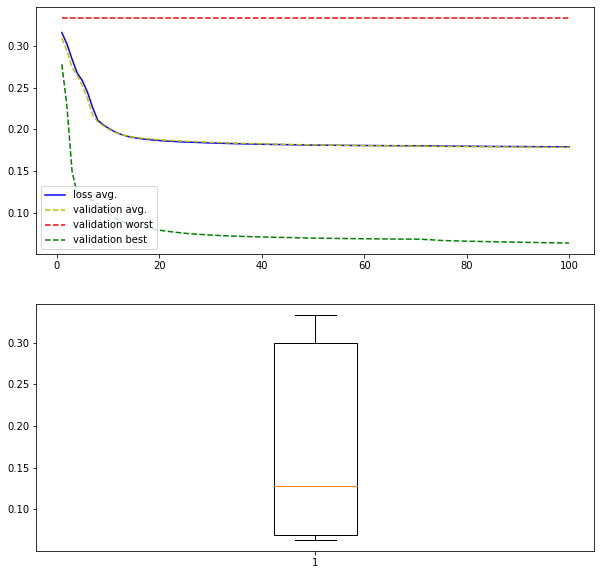

[0.29929739236831665, 0.12757712602615356, 0.06959865987300873, 0.333333283662796, 0.0636608675122261]


In [16]:
model_gen = lambda: get_keras_model(dataset_shapes)
test_model_multiple(model_gen, tr_d, ts_d, num_tries)

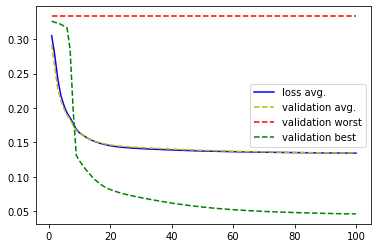

In [77]:
model_gen = lambda: get_simple_vector_model(dataset_shapes)
test_model_multiple(model_gen, tr_d, ts_d, num_tries)

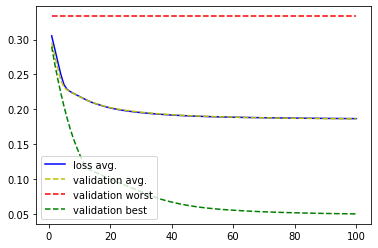

In [78]:
model_gen = lambda: get_fractal_vector_model(dataset_shapes, is_shared=False)
test_model_multiple(model_gen, tr_d, ts_d, num_tries)

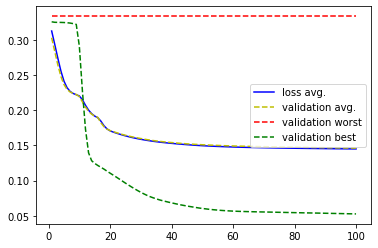

In [79]:
model_gen = lambda: get_fractal_vector_model(dataset_shapes, is_shared=True)
test_model_multiple(model_gen, tr_d, ts_d, num_tries)

### Testing of models in single run, summaries of models

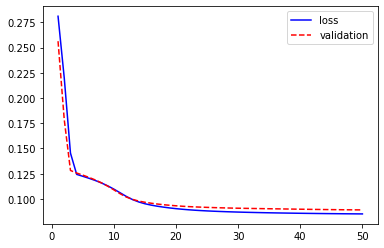

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 21)]              0         
_________________________________________________________________
dense_4 (Dense)              (None, 9)                 198       
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 60        
_________________________________________________________________
dense_6 (Dense)              (None, 4)                 28        
_________________________________________________________________
dense_7 (Dense)              (None, 3)                 15        
Total params: 301
Trainable params: 301
Non-trainable params: 0
_________________________________________________________________
None


In [7]:
model = get_keras_model(dataset_shapes)
# validate_model(model, get_validation_datasets('wine'))
test_model(model, tr_d, ts_d)
print(model.summary())

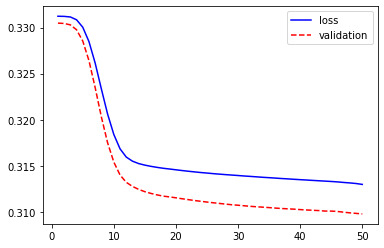

Model: "model_346"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_347 (InputLayer)       [(None, 21)]              0         
_________________________________________________________________
v_input_356 (VInput)         (None, 22, 9)             198       
_________________________________________________________________
v_dense_112 (VDense)         (None, 10, 6)             60        
_________________________________________________________________
v_dense_113 (VDense)         (None, 7, 4)              28        
_________________________________________________________________
v_dense_114 (VDense)         (None, 5, 3)              15        
_________________________________________________________________
v_output_354 (VOutput)       (None, 3)                 0         
Total params: 301
Trainable params: 301
Non-trainable params: 0
___________________________________________________________

In [60]:
model = get_simple_vector_model(dataset_shapes)
# validate_model(model, get_validation_datasets('wine'))
test_model(model, tr_d, ts_d)
model.summary()

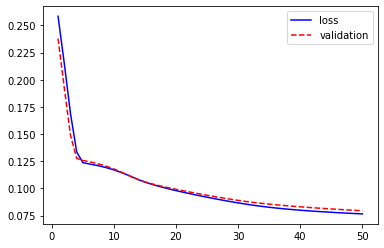

Model: "model_395"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_396 (InputLayer)       [(None, 21)]              0         
_________________________________________________________________
v_input_408 (VInput)         (None, 22, 4)             88        
_________________________________________________________________
v_fractal_302 (VFractal)     (None, 5, 3)              227       
_________________________________________________________________
v_output_407 (VOutput)       (None, 3)                 0         
Total params: 315
Trainable params: 315
Non-trainable params: 0
_________________________________________________________________


In [68]:
model = get_fractal_vector_model(dataset_shapes, is_shared=False)
test_model(model, tr_d, ts_d)
model.summary()

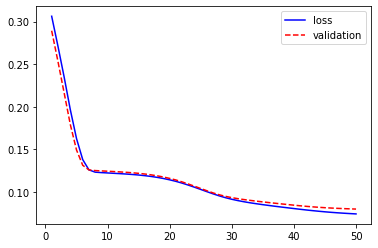

Model: "model_394"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_395 (InputLayer)       [(None, 21)]              0         
_________________________________________________________________
v_input_406 (VInput)         (None, 22, 4)             88        
_________________________________________________________________
v_fractal_300 (VFractal)     (None, 5, 3)              17        
_________________________________________________________________
v_output_405 (VOutput)       (None, 3)                 0         
Total params: 105
Trainable params: 105
Non-trainable params: 0
_________________________________________________________________


In [67]:
model = get_fractal_vector_model(dataset_shapes, is_shared=True)
test_model(model, tr_d, ts_d)
model.summary()